# ANES

In previous notebooks, I've used data from the [General Social Survey](https://gss.norc.org/) (GSS) to see if there is a growing gender gap in political alignment, party affiliation, or political attitudes. So far, the answer is no.

* Women are more likely to say they are liberal by 5-10 percentage points. But there is little or no evidence that the gap is growing. 

* Women are more likely than men to say they are Democrats. In the 1990s, the gap was almost 20 percentage points. Now it is only 5-10 percentage points. So there's no evidence this gap is growing — if anything, it is shrinking.

* To 15 questions related to policies and attitudes, men give slightly more conservative responses than women, on average, but the gap is small and consistent over time — there is no evidence it is growing.

[Ryan Burge has done a similar analysis](https://twitter.com/ryanburge/status/1751615375408521623) with data from the [Cooperative Election Study](https://cces.gov.harvard.edu/) (CSE). Looking at stated political alignment, he finds that women are more likely to say they are liberal by 5-10 percentage points. But there is no evidence that the gap is growing.

That leaves one other long-running survey to consider, the [American National Election Studies](https://electionstudies.org/) (ANES).
I have been meaning to explore this dataset for a long time, so this project is a perfect excuse.

This notebook explores alignment and party affiliation.
I'll get to beliefs and attitudes next week.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_gap.ipynb) -- but you will have to download the data yourself, because I am not allowed to redistribute it.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [3]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

In [4]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [5]:
def values(series):
    return series.value_counts(dropna=False).sort_index()

## Read the Data

I'm using data I previous cleaned in [this notebook](https://github.com/AllenDowney/GssExtract/blob/main/notebooks/01_make_pacs_extract.ipynb).

In [6]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

[You can get the data here](https://electionstudies.org/data-center/anes-time-series-cumulative-data-file/) -- but you'll need to create an account.

In [7]:
df = pd.read_stata('anes_timeseries_cdf_stata_20220916.dta', convert_categoricals=False)
df.shape

(68224, 1030)

In [8]:
column_dict = {'VCF0004': 'year',
               'VCF0803': 'polviews',
               'VCF0301': 'partyid',
               'VCF0302': 'partyid3',
               'VCF0104': 'sex',
               'VCF0101': 'age',
               'VCF0009z': 'wtsamp'}

df = df.rename(columns=column_dict)

In [9]:
recode_polviews = {
    1: "Liberal",
    2: "Moderate",
    3: "Conservative",
}
df["polviews3"] = df["VCF0804"].replace(recode_polviews)
df["polviews3"].value_counts()

polviews3
Conservative    15631
Moderate        12532
Liberal         10984
9.0              9568
0.0              4193
Name: count, dtype: int64

In [10]:
df['wtsamp'].describe()

count    68224.000000
mean         1.039790
std          0.564906
min          0.021200
25%          0.896200
50%          1.000000
75%          1.000000
max          6.932929
Name: wtsamp, dtype: float64

In [11]:
values(df['year'])

year
1948.0     662
1952.0    1899
1954.0    1139
1956.0    1762
1958.0    1450
1960.0    1181
1962.0    1297
1964.0    1571
1966.0    1291
1968.0    1557
1970.0    1507
1972.0    2705
1974.0    1575
1976.0    2248
1978.0    2304
1980.0    1614
1982.0    1418
1984.0    2257
1986.0    2176
1988.0    2040
1990.0    1980
1992.0    2485
1994.0    1795
1996.0    1714
1998.0    1281
2000.0    1807
2002.0    1511
2004.0    1212
2008.0    2322
2012.0    5914
2016.0    4270
2020.0    8280
Name: count, dtype: int64

In [12]:
values(df['sex'])

sex
0.0      211
1.0    30612
2.0    37390
3.0       11
Name: count, dtype: int64

In [13]:
values(df['age'])

age
0.0      887
17.0      21
18.0     498
19.0     605
20.0     690
        ... 
96.0       3
97.0       2
98.0       2
99.0       4
NaN     1801
Name: count, Length: 85, dtype: int64

In [14]:
df['age'].replace(0, np.nan, inplace=True)

In [15]:
values(df['polviews'])

polviews
0.0     2400
1.0     1229
2.0     4821
3.0     4934
4.0    12532
5.0     6567
6.0     7523
7.0     1541
9.0    11361
NaN    15316
Name: count, dtype: int64

In [16]:
values(df['VCF0804'])

VCF0804
0.0     4193
1.0    10984
2.0    12532
3.0    15631
9.0     9568
NaN    15316
Name: count, dtype: int64

In [17]:
values(df['partyid3'])

partyid3
1.0    14125
2.0    15856
3.0     2937
4.0      733
5.0    20437
8.0      133
9.0      244
NaN    13759
Name: count, dtype: int64

In [18]:
def make_diff(df):
    """Compute % liberal minus % conservative.
    """
    year = df["year"]
    column = df["polviews3"]

    xtab = pd.crosstab(year, column, normalize='index')
    diff = xtab['Liberal'] - xtab['Conservative']
    
    return diff * 100

In [19]:
def decorate_plot(title):
    decorate(xlabel='Year',
             ylabel='% liberal - % conservative',
             title=title)

## Make the plot with all respondents


In [20]:
def make_plot(df, title=''):
    """Plot % liberal - % conservative for male and female respondents.
    """
    male = df.query('sex==1')
    female = df.query('sex==2')

    diff_male = make_diff(male)
    diff_female = make_diff(female)

    plot_series_lowess(diff_male, color='C0', label='Male')
    plot_series_lowess(diff_female, color='C1', label='Female')
    decorate_plot(title)

Generate the plot for all respondents.

In [21]:
def savefig(filename, **options):
    if 'dpi' not in options:
        options['dpi'] = 300
    plt.savefig(filename, **options)

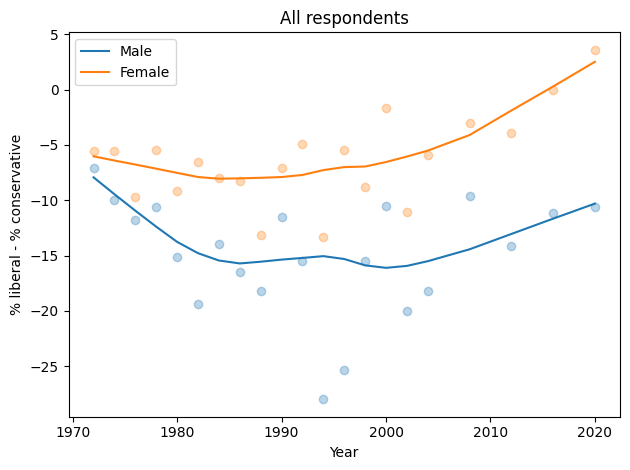

In [22]:
make_plot(df, 'All respondents')
savefig('anes_gap1.png')

In the general population, men are more likely to say they are conservative by 5-10 percentage points. 

The gap might have increased in the most recent data, depending on how seriously we take the last two points in a noisy series.

## Just young people

Now let's select just people under 30.

In [23]:
subset = df.query('age < 30')
subset.shape

(12297, 1031)

And make the same figure.

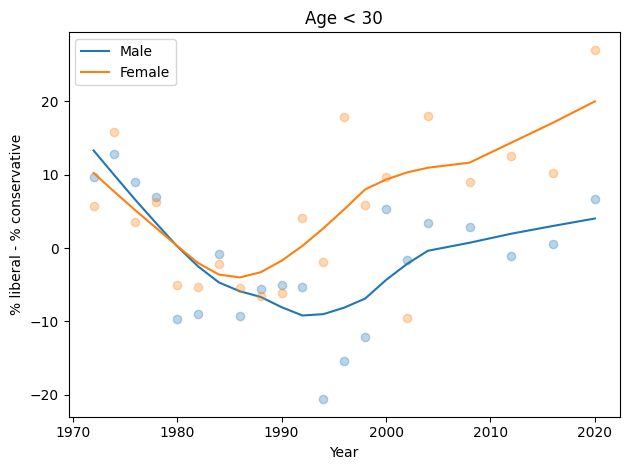

In [24]:
make_plot(subset, 'Age < 30')
savefig('anes_gap2.png')

Here are the sample sizes.

In [25]:
year = subset["year"]
column = subset["sex"]
xtab = pd.crosstab(column, year)
xtab

year,1952.0,1956.0,1958.0,1960.0,1962.0,1964.0,1966.0,1968.0,1970.0,1972.0,...,1994.0,1996.0,1998.0,2000.0,2002.0,2004.0,2008.0,2012.0,2016.0,2020.0
sex,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1.0,143,119,72,39,91,128,105,123,120,339,...,160,110,124,114,63,117,177,443,324,459
2.0,177,186,116,67,110,162,131,163,194,405,...,162,145,118,165,84,122,233,493,323,540
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


## With Sampling Weights

In the previous figures, I have not taken into account the sampling weights.
Let's do that now.

In [26]:
male = subset.query('sex==1')
female = subset.query('sex==2')

diff_male = make_diff(male)
diff_female = make_diff(female)

I'll select only the years that have the `wtsamp` sampling weights.


In [27]:
recent = df.dropna(subset=['wtsamp']).query('age < 30').copy()

In [28]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

In [29]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby("year")
    samples = [resample_rows_weighted(group, column) for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

In [30]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, _ = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [31]:
def plot_percentiles(series_seq, ps=None, label=None, **options):
    """Plot the low, median, and high percentiles.

    series_seq: sequence of Series
    ps: percentiles to use for low, medium and high
    label: string label for the median line
    options: options passed plt.plot and plt.fill_between
    """
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    assert len(ps) == 3

    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

## Resampling and smoothing

In [32]:
def resample_diffs_smooth(df, query, iters=101):
    diffs = []
    for i in range(iters):
        sample = resample_by_year(df, "wtsamp").query(query)
        diff = make_diff(sample)
        smooth = make_lowess(diff)
        diffs.append(smooth)
    return diffs

In [33]:
diffs_male = resample_diffs_smooth(recent, 'sex==1')
diffs_female = resample_diffs_smooth(recent, 'sex==2')

Here's a version of the same plot with moderate smoothing, and dropping the unweighted data.

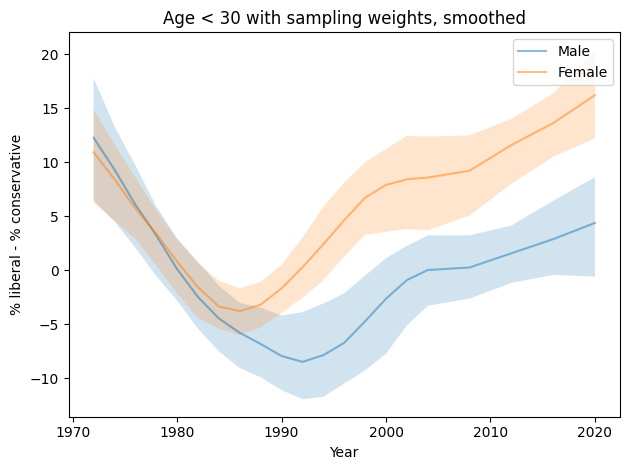

In [34]:
plot_percentiles(diffs_male, label='Male')
plot_percentiles(diffs_female, label='Female')

decorate_plot('Age < 30 with sampling weights, smoothed')
savefig('anes_gap3.png')

## Party Affiliation

In [35]:
def make_diff(df):
    """Compute % Democrat minus % Republican.
    """
    year = df["year"]
    column = df["partyid3"]

    xtab = pd.crosstab(year, column, normalize='index')
    diff = xtab[5] - xtab[1]
    
    return diff * 100

In [36]:
diffs_male = resample_diffs_smooth(recent, 'sex==1')
diffs_female = resample_diffs_smooth(recent, 'sex==2')

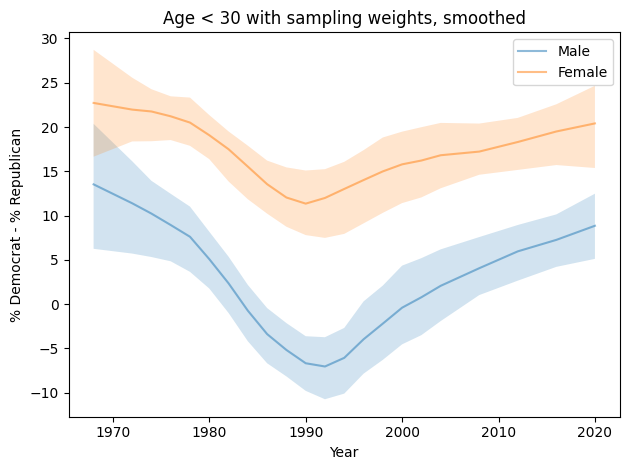

In [37]:
plot_percentiles(diffs_male, label='Male')
plot_percentiles(diffs_female, label='Female')

decorate_plot('Age < 30 with sampling weights, smoothed')
plt.ylabel('% Democrat - % Republican')

savefig('anes_gap4.png')